In [1]:
import sklearn
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_scores, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='green', label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='black')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import fbeta_score



def plot_performance(x_test, y_true, model, model_name):
    fig, axs = plt.subplots(1, 4, figsize=(25, 4))

    ConfusionMatrixDisplay.from_estimator(model, x_test, y_true, ax=axs[0])

    fpr, tpr, _ = roc_curve(y_true, model.predict_proba(x_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    axs[1].plot(fpr, tpr, color='green', label=f'ROC curve (area = {roc_auc:.5f})')
    axs[1].plot([0, 1], [0, 1], color='black')
    axs[1].set_xlim([0.0, 1.0])
    axs[1].set_ylim([0.0, 1.05])
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive Rate')
    axs[1].set_title(f'RoC- {model_name}')
    axs[1].legend(loc="lower right")
    axs[1].grid()

    beta_x = []
    f1_y = []

    for beta in np.arange(0.1, 3.0, 0.2):
        fbeta = fbeta_score(y_true, model.predict(x_test), beta=beta)
        beta_x.append(beta)
        f1_y.append(fbeta)
    
    axs[2].plot(beta_x, f1_y, marker='o')
    axs[2].set_xlabel("Beta")
    axs[2].set_ylabel("F-Beta Score")
    axs[2].set_title(f"F-Beta Score vs Beta - {model_name}")
    axs[2].grid()   

    accuracy = sklearn.metrics.accuracy_score(y_true, model.predict(x_test))
    f1_score = sklearn.metrics.f1_score(y_true, model.predict(x_test))
    recall = sklearn.metrics.recall_score(y_true, model.predict(x_test))
    precision = sklearn.metrics.precision_score(y_true, model.predict(x_test))

    axs[3].text(0.1, 0.8, f'Accuracy: {accuracy*100:.2f}%', fontsize=12)
    axs[3].text(0.1, 0.6, f'F1 Score: {f1_score*100:.2f}%', fontsize=12)
    axs[3].text(0.1, 0.4, f'Recall: {recall*100:.2f}%', fontsize=12)
    axs[3].text(0.1, 0.2, f'Precision: {precision*100:.2f}%', fontsize=12)
    axs[3].axis('off')
    plt.show()
    fig.tight_layout()
    

    


## Q1.1 Load the dataset, inspect feature names and target distribution. Comment on dataset imbalance.

Load the dataset, we reserve 20% of data for testing before doing anything. This will be used as unseen data for testing later. It is split using stratify so that the class distribution is preserved in both set.

In [4]:
df = sklearn.datasets.load_breast_cancer(return_X_y=False, as_frame=True)
data = df.data
target = df.target

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)




In [5]:
print("Features of data: ", X_train.columns.tolist())
print("Numbers of features: ", X_train.columns.value_counts().sum())

Features of data:  ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']
Numbers of features:  30


In [6]:
print("Target distribution:\n")
print("Malignant: ", np.sum(y_train==0))
print("Benign: ", np.sum(y_train==1))
print("Total: ", y_train.shape[0], "\n")

print("Distribution percentages:")
print("Malignant: ", np.sum(y_train==0) / y_train.shape[0] * 100)
print("Benign: ", np.sum(y_train==1) / y_train.shape[0] * 100)

Target distribution:

Malignant:  170
Benign:  285
Total:  455 

Distribution percentages:
Malignant:  37.362637362637365
Benign:  62.637362637362635


#### Distibution
We see that the distribution is about 63% to 37%, meaning that this is not a very imbalanced dataset, but still it is not 50/50, meaning that a model always guessign Benign would get 63% accuracy. Thus we should think to not use accuracy and ROC only to measure the model, but look at other metrics like precision and recall, which is good for inbalanced datasets.

## Q1.2 Analyze all features with and without standardization (i.e., zero mean and unit variance). Plot the feature analysis with and without standardization and decidewhich version is more suitable.

## Analyzing features:

### Without normalization

In [7]:
X_train.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,14.067213,19.247363,91.557407,648.541099,0.096167,0.103869,0.089193,0.048344,0.180618,0.062820,...,16.177226,25.647297,106.625297,869.026593,0.132329,0.254329,0.276578,0.113904,0.290865,0.083945
std,3.499380,4.405291,24.149231,344.944564,0.013458,0.053522,0.081747,0.038925,0.028074,0.007159,...,4.770020,6.225470,33.195053,552.926912,0.022550,0.159882,0.215937,0.066784,0.064624,0.018408
min,6.981000,9.710000,43.790000,143.500000,0.062510,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.635000,16.000000,74.720000,415.650000,0.086475,0.063750,0.028010,0.020220,0.161750,0.057685,...,13.010000,21.090000,83.715000,513.900000,0.115950,0.145850,0.107900,0.063390,0.249400,0.071835
50%,13.270000,18.820000,85.980000,541.800000,0.095660,0.090970,0.059990,0.032630,0.178100,0.061440,...,14.910000,25.400000,97.590000,683.400000,0.131400,0.211600,0.229800,0.097220,0.281900,0.079930
75%,15.740000,21.710000,103.700000,770.050000,0.104850,0.130100,0.132200,0.073820,0.195300,0.066250,...,18.550000,29.370000,124.950000,1033.500000,0.146200,0.336800,0.385300,0.162500,0.320100,0.092070
max,28.110000,39.280000,188.500000,2499.000000,0.144700,0.345400,0.426800,0.201200,0.304000,0.097440,...,33.130000,49.540000,229.300000,3432.000000,0.218400,1.058000,1.252000,0.291000,0.663800,0.207500


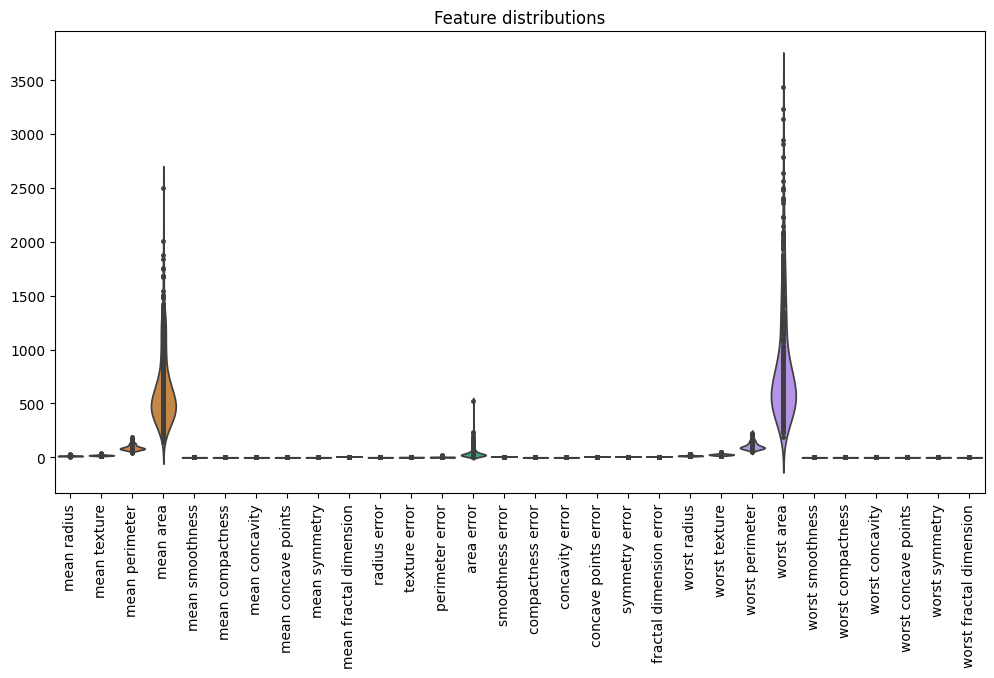

In [8]:

plt.figure(figsize=(12,6))
sns.violinplot(data=X_train, inner="point", density_norm="width")
plt.xticks(rotation=90)
plt.title("Feature distributions")
plt.show()

Here we see that the feature data scales is widely different, especially mean area and worst area which have the majority of its data far above the others in terms of scale. For some models like Decision trees, this will not matter, but for models like regression and SVM like similar data. This is because the models will put more weight on the large-scale features and can make training unstable.

Create a pipeline for preprocessing numerical data. It includes a imputer, which if any NaN values are delivered to the pipeline it will just fill it with the mean of the column. Then it goes through the standarizer, which scales it to zero mean and unit variance. This is useful for models that work better with normal-like data like linear/logistic regression and SVMs.
Min-max scaling could also be an option

In [9]:
num_pipeline = sklearn.pipeline.Pipeline([
    ("impute", sklearn.impute.SimpleImputer(strategy="median")),
    ("standarize", sklearn.preprocessing.StandardScaler())
])

X_train_scaled = num_pipeline.fit_transform(X_train)
X_train_scaled = pd.DataFrame(
    X_train_scaled,
    columns=X_train.columns, 
    index=X_train.index      
)



In [10]:
X_train_scaled.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,...,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02
mean,-2.928061e-16,6.246530e-16,-1.629954e-16,-1.717796e-16,6.246530e-17,-2.088683e-16,-1.561632e-17,6.636938e-17,-2.928061e-16,8.735381e-16,...,4.157846e-16,-3.123265e-17,-2.557173e-16,2.342449e-17,4.714178e-16,-1.952040e-16,1.444510e-16,-2.732857e-17,-1.756836e-16,1.756836e-16
std,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,...,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00
min,-2.027220e+00,-2.167362e+00,-1.980187e+00,-1.465734e+00,-2.503730e+00,-1.580330e+00,-1.092292e+00,-1.243358e+00,-2.660791e+00,-1.798182e+00,...,-1.730874e+00,-2.191368e+00,-1.695348e+00,-1.238101e+00,-2.715107e+00,-1.421602e+00,-1.282241e+00,-1.707442e+00,-2.081459e+00,-1.571972e+00
25%,-6.958063e-01,-7.379620e-01,-6.979907e-01,-6.758983e-01,-7.210063e-01,-7.504076e-01,-7.492716e-01,-7.233200e-01,-6.728116e-01,-7.179958e-01,...,-6.647169e-01,-7.328464e-01,-6.909317e-01,-6.429737e-01,-7.271308e-01,-6.792384e-01,-7.820068e-01,-7.572169e-01,-6.423407e-01,-6.585793e-01
50%,-2.280663e-01,-9.711800e-02,-2.312101e-01,-3.097848e-01,-3.774691e-02,-2.412686e-01,-3.576338e-01,-4.041472e-01,-8.978972e-02,-1.929345e-01,...,-2.659572e-01,-3.976710e-02,-2.724877e-01,-3.360859e-01,-4.123889e-02,-2.675449e-01,-2.168678e-01,-2.501005e-01,-1.388815e-01,-2.183342e-01
75%,4.785500e-01,5.596334e-01,5.033684e-01,3.526440e-01,6.458845e-01,4.906419e-01,5.266743e-01,6.552186e-01,5.235422e-01,4.796473e-01,...,4.979823e-01,5.986377e-01,5.526388e-01,2.977870e-01,6.157967e-01,5.163947e-01,5.040438e-01,7.284559e-01,4.528766e-01,4.418976e-01
max,4.017353e+00,4.552410e+00,4.018733e+00,5.370416e+00,3.610271e+00,4.517740e+00,4.134445e+00,3.931305e+00,4.399657e+00,4.840942e+00,...,3.557938e+00,3.842120e+00,3.699640e+00,4.640386e+00,3.821065e+00,5.032188e+00,4.522140e+00,2.654689e+00,5.777151e+00,6.719538e+00


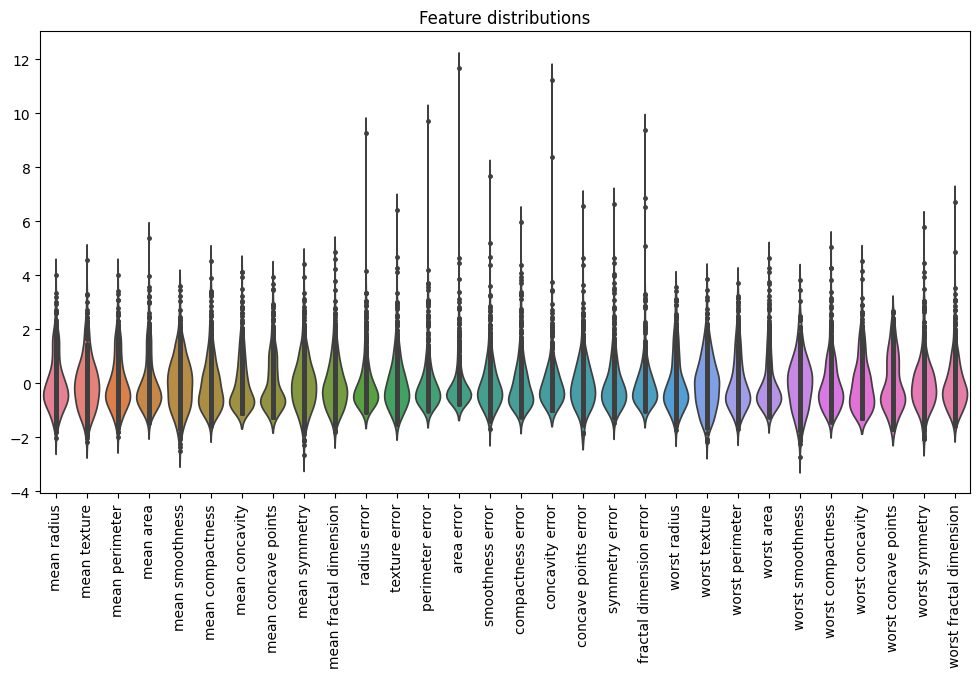

In [11]:


plt.figure(figsize=(12,6))
sns.violinplot(data=X_train_scaled, inner="point", density_norm="width")
plt.xticks(rotation=90)
plt.title("Feature distributions")
plt.show()

We see from the description of the scaled input variables that the mean have now gone down to 0 and that the standard deviation is 1. The plot also shows that most of the data is alligned and similar, which should make training with SVM and regression much more stable. We can then conclude that the features that are standardized are mure suitable for further usage.

## Q1.3 Comment on importance of three way split with respect to hyperparameter search and robustness of any learned model.

Hyperparameters are settings we choose before any training and controls how the learning process is performed. This can be parameters like learning rate, batch rate, regularization parameters or even layers/neurons in deep neural nets. This directly affect how you model turns out and its performance. To get the best hyperparameters we need to test different one to find the ones that yields the best results. To do this we need to have a seperate set of the data to test against and check the models performance. If we were to use the test set, we would break the norm of leaving the test set untouched until the end. This is because we would effectively tweak the model and train if after the testing set. The solution to this is then to create another split from the training data into a validation set. We will then use this validation set to evaluate the model during training and use the result for tweaking of the model to achieve the best result. This will result in a more robust model, because it prevents overfitting and we will in the end have a dataset that the model have not have any interaction with to test its real performance to unseen data.

In [12]:
X_train, X_validation, y_train, y_validation = sklearn.model_selection.train_test_split(X_train_scaled, y_train, test_size=0.25, stratify=y_train, random_state=42)

Now we split the training data into training and validation data. These will be used for training and tweaking of the parameters.

In [13]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

x_training_splits = list(cv.split(X_train, y_train))



## Exercise-2: Decision Trees

### Q2.1 Train a Decision Tree classifier using default parameters. Evaluate it on validation sets from original splits (report accuracy mean and std).

In [14]:
from sklearn.tree import DecisionTreeClassifier

In [15]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [16]:
y_validation_class_0_percent = np.sum(y_validation==0) / y_validation.shape[0] * 100
y_validation_class_1_percent = np.sum(y_validation==1) / y_validation.shape[0] * 100
print("Validation set class distribution:")
print("Class 0: ", y_validation_class_0_percent)
print("Class 1: ", y_validation_class_1_percent)

Validation set class distribution:
Class 0:  37.719298245614034
Class 1:  62.28070175438597


In [17]:

train_acc = sklearn.metrics.accuracy_score(y_train, tree_model.predict(X_train))
print(f"Training Accuracy: {train_acc*100:.2f}% \n")


y_pred_val = tree_model.predict(X_validation)
accuracy = sklearn.metrics.accuracy_score(y_validation, y_pred_val)
print(f"Validation Accuracy: {accuracy*100:.2f}%")



Training Accuracy: 100.00% 

Validation Accuracy: 95.61%


In [18]:
leaf_count = tree_model.get_n_leaves()
print(f"Number of leaves in the tree: {leaf_count}")
depth = tree_model.get_depth()
print(f"Depth of the tree: {depth}")


Number of leaves in the tree: 15
Depth of the tree: 6


This is the result of a completely standard single decision tree, with standard parameters. We see that the model ended with a depth of 6 and 16 total leaves in the tree. These make out the complexity of the model and when is not regularized, can result in the model overfitting to the data. We see that the model achieved a training accuracy of 100% on the training data, but when evaluated on validation it drops to 94%. This is because the tree is overfitting on the training data and drops in performance when seeing new data. 

### Decision tree

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

accuracy_scores = []

for i, (train_idx, val_idx) in enumerate(x_training_splits):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    tree_model.fit(X_tr, y_tr)
    val_pred = tree_model.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    print(f"Fold {i+1} Validation Accuracy: {val_acc:.3f}")
    accuracy_scores.append(val_acc)

mean_acc = np.mean(accuracy_scores)
std_acc = np.std(accuracy_scores)
print(f"\nMean Validation Accuracy: {mean_acc:.3f}")
print(f"Standard Deviation of Validation Accuracy: {std_acc:.3f}")




Fold 1 Validation Accuracy: 0.942
Fold 2 Validation Accuracy: 0.926
Fold 3 Validation Accuracy: 0.956
Fold 4 Validation Accuracy: 0.868
Fold 5 Validation Accuracy: 0.956

Mean Validation Accuracy: 0.930
Standard Deviation of Validation Accuracy: 0.033


Here we do cross validation on 5 different splits on the training data just to analyze the variance of the splitting of training data and validation. We see that the best our model achieve is 97.3% accuracy on the validation split, but the average is around 92.2%

### Random forest result

In [20]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

accuracy_scores = []

for split in range(1,6):
    X_tr, X_val = X_train.iloc[x_training_splits[split-1][0]], X_train.iloc[x_training_splits[split-1][1]]
    y_tr, y_val = y_train.iloc[x_training_splits[split-1][0]], y_train.iloc[x_training_splits[split-1][1]]
    
    rf_model.fit(X_tr, y_tr)
    val_pred = rf_model.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    print(f"Fold {split} Random Forest Validation Accuracy: {val_acc:.3f}")
    accuracy_scores.append(val_acc)

mean_acc = np.mean(accuracy_scores)
std_acc = np.std(accuracy_scores)
print(f"\nRandom Forest Mean Validation Accuracy: {mean_acc:.3f}")
print(f"Random Forest Standard Deviation of Validation Accuracy: {std_acc:.3f}")


Fold 1 Random Forest Validation Accuracy: 0.986
Fold 2 Random Forest Validation Accuracy: 0.941
Fold 3 Random Forest Validation Accuracy: 0.971
Fold 4 Random Forest Validation Accuracy: 0.971
Fold 5 Random Forest Validation Accuracy: 0.971

Random Forest Mean Validation Accuracy: 0.968
Random Forest Standard Deviation of Validation Accuracy: 0.014


In [21]:
amount_of_trees = rf_model.n_estimators
print(f"Number of trees in the Random Forest: {amount_of_trees}")

average_depth = np.mean([estimator.get_depth() for estimator in rf_model.estimators_])
print(f"Average depth of trees in the Random Forest: {average_depth:.2f}")

Number of trees in the Random Forest: 100
Average depth of trees in the Random Forest: 5.56


A problem with a decision tree is that the variance of the model is high and its performance can therefor be inconsistent. To reduce this variance we create an ensemble of decision trees and aggregate their results. Here we create a random forest of 100 decision trees and see that the accuracy increased from the decision tree. This model also uses bagging, which samples training data with replacement. This is done to reduce the variance, because the different trees. have very different training data. We still have not included any regularizing parameters, so we see that the forest still overfit on the training data and the accuracy is only around 96.4% on average across splits.

### Q2.2 From the trained model, comment on feature importance values and identify the top 3 features from your model.

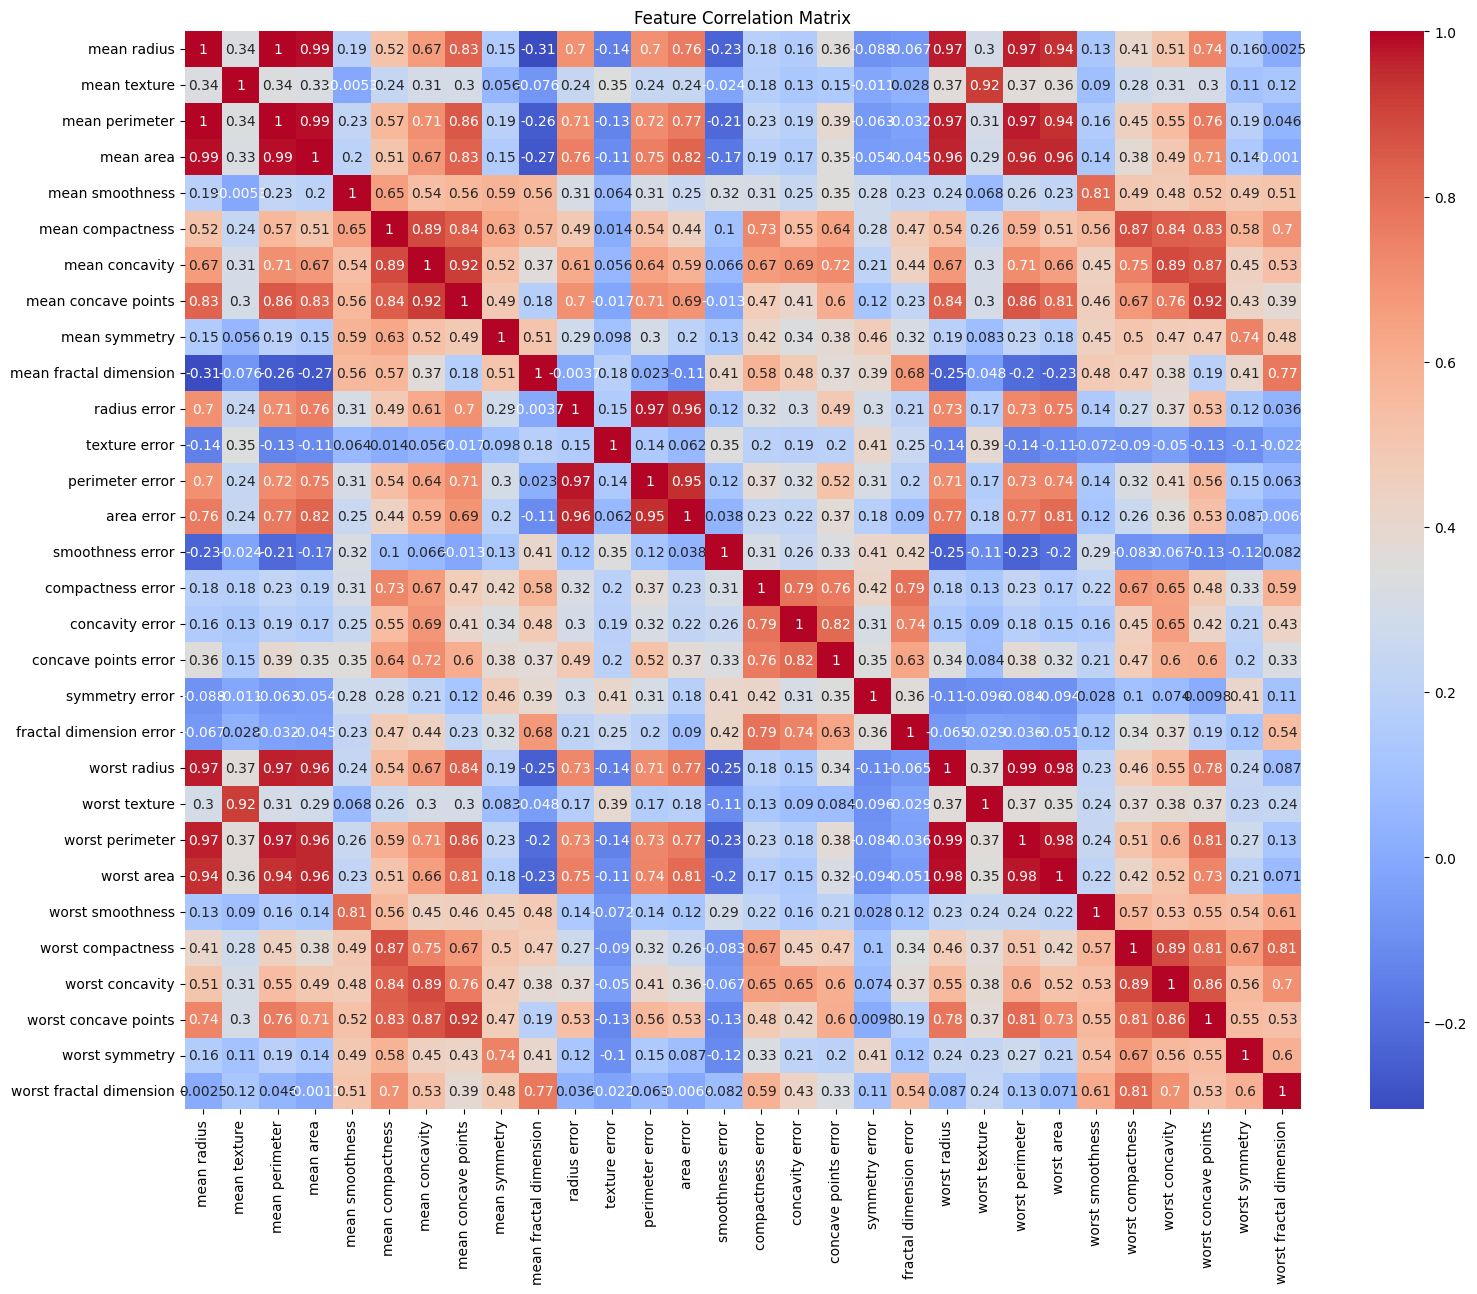

In [22]:
plt.figure(figsize=(18,14))
correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title("Feature Correlation Matrix")
plt.show()

In [23]:
for feature in correlation_matrix.columns:
    high_corr_features = correlation_matrix.index[correlation_matrix[feature] > 0.75].tolist()
    if high_corr_features:
        print(f"Features highly correlated with {feature}: {high_corr_features}")

Features highly correlated with mean radius: ['mean radius', 'mean perimeter', 'mean area', 'mean concave points', 'area error', 'worst radius', 'worst perimeter', 'worst area']
Features highly correlated with mean texture: ['mean texture', 'worst texture']
Features highly correlated with mean perimeter: ['mean radius', 'mean perimeter', 'mean area', 'mean concave points', 'area error', 'worst radius', 'worst perimeter', 'worst area', 'worst concave points']
Features highly correlated with mean area: ['mean radius', 'mean perimeter', 'mean area', 'mean concave points', 'radius error', 'perimeter error', 'area error', 'worst radius', 'worst perimeter', 'worst area']
Features highly correlated with mean smoothness: ['mean smoothness', 'worst smoothness']
Features highly correlated with mean compactness: ['mean compactness', 'mean concavity', 'mean concave points', 'worst compactness', 'worst concavity', 'worst concave points']
Features highly correlated with mean concavity: ['mean compac

In [24]:
for score, name in sorted(zip(rf_model.feature_importances_, X_train.columns), reverse=True)[:3]:
    print(f"Feature: {name}, Importance Score: {score:.4f}")

#correlation between area and concave points and perimiter
print("\n")
print("Correlation between mean area and mean concave points: ", correlation_matrix.loc['mean area', 'mean concave points'])
print("Correlation between mean area and mean perimeter: ", correlation_matrix.loc['mean area', 'mean perimeter'])


Feature: worst concave points, Importance Score: 0.1517
Feature: worst area, Importance Score: 0.1318
Feature: worst perimeter, Importance Score: 0.0965


Correlation between mean area and mean concave points:  0.8280553342626503
Correlation between mean area and mean perimeter:  0.9869793666607827


We see that the most important features are concave points, worst area and perimeter. However when we look at the correlation matrix, all of these have a high correlation and represent the same group. These features could be grouped together as an area group. These features adds useless data and results in redundant computation and can distort interpretation of the model, because their effect overlap.

To remove the redundant features we can use PCA to measure the eigenvector of the correlation matrix and use that as the new features. This will reduce the amount of dimentions which will decrease training time, but will make the model less interpretable. 

### PCA

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


pca = PCA(n_components=0.95)  

X_train_reduced = pca.fit_transform(X_train)
X_train_reduced = pd.DataFrame(X_train_reduced)
x_reduced_splits = list(cv.split(X_train_reduced, y_train))




In [26]:
rf_model_pca = RandomForestClassifier(random_state=42)
accuracy_scores_pca = []

for split in range(1,6):
    X_tr, X_val = X_train_reduced.iloc[x_reduced_splits[split-1][0]], X_train_reduced.iloc[x_reduced_splits[split-1][1]]
    y_tr, y_val = y_train.iloc[x_reduced_splits[split-1][0]], y_train.iloc[x_reduced_splits[split-1][1]]
    
    rf_model_pca.fit(X_tr, y_tr)
    val_pred = rf_model_pca.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    print(f"Fold {split} Random Forest with PCA Validation Accuracy: {val_acc:.3f}")
    accuracy_scores_pca.append(val_acc)

mean_acc_pca = np.mean(accuracy_scores_pca)
std_acc_pca = np.std(accuracy_scores_pca)
print(f"\nRandom Forest with PCA Mean Validation Accuracy: {mean_acc_pca:.3f}")
print(f"Random Forest with PCA Standard Deviation of Validation Accuracy: {std_acc_pca:.3f}")

Fold 1 Random Forest with PCA Validation Accuracy: 0.971
Fold 2 Random Forest with PCA Validation Accuracy: 0.912
Fold 3 Random Forest with PCA Validation Accuracy: 0.985
Fold 4 Random Forest with PCA Validation Accuracy: 0.971
Fold 5 Random Forest with PCA Validation Accuracy: 0.985

Random Forest with PCA Mean Validation Accuracy: 0.965
Random Forest with PCA Standard Deviation of Validation Accuracy: 0.027


### Q2.3 Vary the max depth parameter (e.g., depth 2-10). Use validation accuracy (mean ± std from cross-validation on the training set) to choose the best depth. Provide performance for each chosen depth (at-least 5 to be reported) and discuss the aspects of overfitting vs. underfitting.

In [27]:
split_scored_rf = pd.DataFrame(columns=["Depth", "Mean Accuracy (cv)", "Std Accuracy (cv)"])

In [28]:
for depth in range(2, 11):
    tree_model = RandomForestClassifier(max_depth=depth, random_state=42)
    accuracy_scores = []
    for i, (train_idx, val_idx) in enumerate(x_training_splits):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        tree_model.fit(X_tr, y_tr)
        val_pred = tree_model.predict(X_val)
        val_acc = accuracy_score(y_val, val_pred)
        accuracy_scores.append(val_acc)
    mean_acc = np.mean(accuracy_scores)
    std_acc = np.std(accuracy_scores)
    print(f"Depth: {depth}, Cross-val Accuracy Mean: {mean_acc:.3f}, Std: {std_acc:.3f}")


    split_scored_rf = pd.concat([split_scored_rf, pd.DataFrame({
    "Depth": [depth],
    "Mean Accuracy (cv)": [np.mean(accuracy_scores)],
    "Std Accuracy (cv)": [np.std(accuracy_scores)],
    })], ignore_index=True)

Depth: 2, Cross-val Accuracy Mean: 0.950, Std: 0.022


/tmp/ipykernel_47628/3055257307.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  split_scored_rf = pd.concat([split_scored_rf, pd.DataFrame({


Depth: 3, Cross-val Accuracy Mean: 0.956, Std: 0.021
Depth: 4, Cross-val Accuracy Mean: 0.965, Std: 0.020
Depth: 5, Cross-val Accuracy Mean: 0.968, Std: 0.020
Depth: 6, Cross-val Accuracy Mean: 0.974, Std: 0.020
Depth: 7, Cross-val Accuracy Mean: 0.974, Std: 0.020
Depth: 8, Cross-val Accuracy Mean: 0.968, Std: 0.014
Depth: 9, Cross-val Accuracy Mean: 0.968, Std: 0.014
Depth: 10, Cross-val Accuracy Mean: 0.968, Std: 0.014


In [30]:
split_scored_rf

,Depth,Mean Accuracy (cv),Std Accuracy (cv)
0,2,0.950085,0.022090
1,3,0.955925,0.020858
2,4,0.964706,0.019948
3,5,0.967732,0.019523
4,6,0.973572,0.019535
5,7,0.973529,0.019510
6,8,0.967690,0.014461
7,9,0.967690,0.014461
8,10,0.967690,0.014461


A too complex model will start overfitting on the data and become really good at prediction training data, but is bad at predicting new data. This can be seen of models that have high accuracy at training, but performance drops when validated against new data.

A too simple model will however underfit, because it does not have the degree of freedom to model itself to make meaningful predictions. This can be seen for models with bad performance on testing data.

We see that the model has the best validation accuracy at depth 6, at 96.7% accuracy. Going any higher decreases the validation accruacy and the cross validation accuracy, which would indicate that the model would become to complex and start overfitting on the data. A lower depth on 2 yielded lower accuracy and we see that training accuracy also is low, which would indicate underfitting of the model. This means that a model with depth around 3 have a good balance between complexity and simplicity, where it wont overfit or underfit too much on the training data.

### Q2.4 Repeat previous exercise with different min samples leaf values. Which setting generalizes best according to the validation set?

In [ ]:
split_scored = pd.DataFrame(columns=["Min Leaf", "Mean Accuracy (cv)", "Std Accuracy (cv)", "Mean Validation Score", "Std Validation Score"])

for min_leaf in range(2, 12):
    tree_model = RandomForestClassifier(max_depth=6, min_samples_leaf=min_leaf, random_state=42)
    accuracy_scores = []
    validation_scores = []
    for i, (train_idx, val_idx) in enumerate(x_training_splits):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        tree_model.fit(X_tr, y_tr)
        val_pred = tree_model.predict(X_val)
        val_acc = accuracy_score(y_val, val_pred)
        accuracy_scores.append(val_acc)

        val_score = tree_model.score(X_validation, y_validation)
        validation_scores.append(val_score)

    split_scored = pd.concat([split_scored, pd.DataFrame({
        "Min Leaf": [min_leaf],
        "Mean Accuracy (cv)": [np.mean(accuracy_scores)],
        "Std Accuracy (cv)": [np.std(accuracy_scores)],
        "Mean Validation Score": [np.mean(validation_scores)],
        "Std Validation Score": [np.std(validation_scores)]
    })], ignore_index=True)

    mean_acc = np.mean(accuracy_scores)
    std_acc = np.std(accuracy_scores)
    print(f"Min Leaf: {min_leaf}, Cross-val Accuracy Mean: {mean_acc:.3f}, Std: {std_acc:.3f}")

    mean_val_score = np.mean(validation_scores)
    std_val_score = np.std(validation_scores)
    print(f"Min Leaf: {min_leaf}, Validation Score Mean: {mean_val_score:.3f}, Std: {std_val_score:.3f}")



/tmp/ipykernel_5732/296788265.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  split_scored = pd.concat([split_scored, pd.DataFrame({


Min Leaf: 2, Cross-val Accuracy Mean: 0.965, Std: 0.015
Min Leaf: 2, Validation Score Mean: 0.951, Std: 0.004
Min Leaf: 3, Cross-val Accuracy Mean: 0.971, Std: 0.021
Min Leaf: 3, Validation Score Mean: 0.947, Std: 0.006
Min Leaf: 4, Cross-val Accuracy Mean: 0.956, Std: 0.016
Min Leaf: 4, Validation Score Mean: 0.949, Std: 0.007
Min Leaf: 5, Cross-val Accuracy Mean: 0.956, Std: 0.028
Min Leaf: 5, Validation Score Mean: 0.951, Std: 0.004
Min Leaf: 6, Cross-val Accuracy Mean: 0.956, Std: 0.021
Min Leaf: 6, Validation Score Mean: 0.949, Std: 0.007
Min Leaf: 7, Cross-val Accuracy Mean: 0.953, Std: 0.017
Min Leaf: 7, Validation Score Mean: 0.949, Std: 0.007
Min Leaf: 8, Cross-val Accuracy Mean: 0.941, Std: 0.031
Min Leaf: 8, Validation Score Mean: 0.946, Std: 0.007
Min Leaf: 9, Cross-val Accuracy Mean: 0.941, Std: 0.031
Min Leaf: 9, Validation Score Mean: 0.947, Std: 0.008
Min Leaf: 10, Cross-val Accuracy Mean: 0.944, Std: 0.029
Min Leaf: 10, Validation Score Mean: 0.946, Std: 0.010
Min Leaf

In [ ]:
split_scored

,Min Leaf,Mean Accuracy (cv),Std Accuracy (cv),Mean Validation Score,Std Validation Score
0,2,0.964791,0.015031,0.950877,0.004297
1,3,0.970588,0.020797,0.947368,0.005548
2,4,0.955968,0.016188,0.949123,0.006564
3,5,0.955882,0.027902,0.950877,0.004297
4,6,0.955925,0.020858,0.949123,0.006564
5,7,0.953026,0.017238,0.949123,0.006564
6,8,0.941262,0.030929,0.945614,0.006564
7,9,0.941262,0.030929,0.947368,0.007846
8,10,0.944203,0.028595,0.945614,0.010230
9,11,0.941262,0.026402,0.945614,0.010230


### Best score is minimum leaf 1 with 97%

### Check estimators


In [34]:
for estimators in [10, 50, 100, 200, 250]:
    tree_model = RandomForestClassifier(n_estimators=estimators, max_depth=6, min_samples_leaf=1, random_state=42)
    accuracy_scores = []
    for i, (train_idx, val_idx) in enumerate(x_training_splits):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        tree_model.fit(X_tr, y_tr)
        val_pred = tree_model.predict(X_val)
        val_acc = accuracy_score(y_val, val_pred)
        accuracy_scores.append(val_acc)
    mean_acc = np.mean(accuracy_scores)
    std_acc = np.std(accuracy_scores)
    print(f"Estimators: {estimators}, Cross-val Accuracy Mean: {mean_acc:.3f}, Std: {std_acc:.3f}")

Estimators: 10, Cross-val Accuracy Mean: 0.962, Std: 0.020
Estimators: 50, Cross-val Accuracy Mean: 0.968, Std: 0.031
Estimators: 100, Cross-val Accuracy Mean: 0.974, Std: 0.020
Estimators: 200, Cross-val Accuracy Mean: 0.971, Std: 0.021
Estimators: 250, Cross-val Accuracy Mean: 0.968, Std: 0.017


Here we do the same using depth 4 and testing different minimum leaf samples. We see that the validation accuracy is best at minimum leaf = 10 and the model seems to be underfit before that.

### Training accuracy

In [80]:
accuracy_scores = []

for split in range(1,6):
    tree_model = RandomForestClassifier(max_depth=6, random_state=42, min_samples_leaf=1, n_estimators=100)

    X_tr, X_val = X_train.iloc[x_training_splits[split-1][0]], X_train.iloc[x_training_splits[split-1][1]]
    y_tr, y_val = y_train.iloc[x_training_splits[split-1][0]], y_train.iloc[x_training_splits[split-1][1]]
    
    rf_model.fit(X_tr, y_tr)
    val_pred = rf_model.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    print(f"Fold {split} Random Forest Validation Accuracy: {val_acc:.3f}")
    accuracy_scores.append(val_acc)

mean_acc = np.mean(accuracy_scores)
std_acc = np.std(accuracy_scores)
print(f"\nRandom Forest Mean training Accuracy: {mean_acc:.3f}")
print(f"Random Forest Standard Deviation of Validation Accuracy: {std_acc:.3f}")


Fold 1 Random Forest Validation Accuracy: 0.986
Fold 2 Random Forest Validation Accuracy: 0.941
Fold 3 Random Forest Validation Accuracy: 0.971
Fold 4 Random Forest Validation Accuracy: 0.971
Fold 5 Random Forest Validation Accuracy: 0.971

Random Forest Mean training Accuracy: 0.968
Random Forest Standard Deviation of Validation Accuracy: 0.014


### Validation accuracy

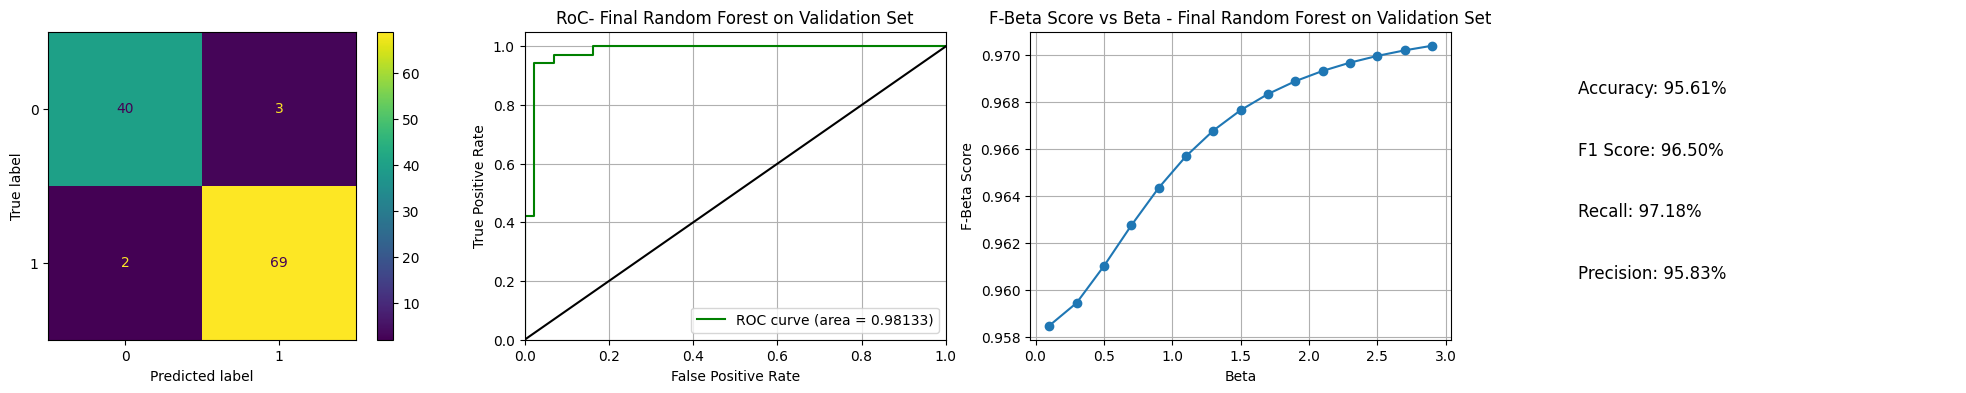

In [82]:
final_tree_model = RandomForestClassifier(max_depth=6, random_state=42, min_samples_leaf=3, n_estimators=200)
final_tree_model.fit(X_train, y_train)
final_val_pred = final_tree_model.predict(X_validation)
final_val_acc = accuracy_score(y_validation, final_val_pred)
final_val_recall = sklearn.metrics.recall_score(y_validation, final_val_pred)
final_val_precision = sklearn.metrics.precision_score(y_validation, final_val_pred)
final_val_f1 = sklearn.metrics.f1_score(y_validation, final_val_pred)

plot_performance(X_validation, y_validation, final_tree_model, "Final Random Forest on Validation Set")



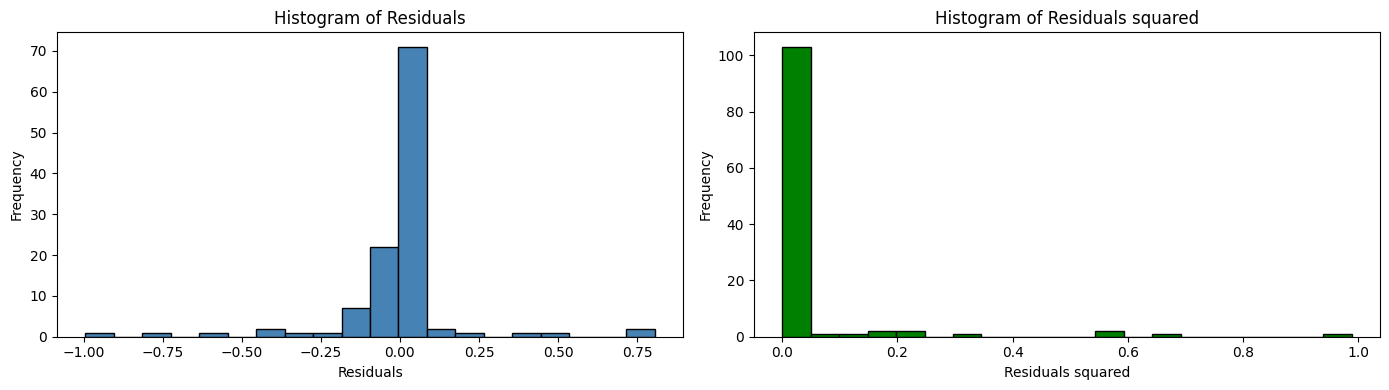

In [ ]:
y_prob = final_tree_model.predict_proba(X_validation)[:, 1]

residuals = y_validation - y_prob

fig, axs = plt.subplots(1, 2, figsize=(14, 4))

axs[0].hist(residuals, bins=20, color='steelblue', edgecolor='black')
axs[0].set_xlabel("Residuals")
axs[0].set_ylabel("Frequency")
axs[0].set_title("Histogram of Residuals")

axs[1].hist(residuals**2, bins=20, color='green', edgecolor='black')
axs[1].set_xlabel("Residuals squared")
axs[1].set_ylabel("Frequency")
axs[1].set_title("Histogram of Residuals squared")


plt.tight_layout()
plt.show()

The resiudla. will not have a mean of 0 for classifier, because it is rare that the model predict 0 or 100% exactly.

## Exercise-3: Support Vector Machines (SVM)

### Q3.1 Train a linear SVM (kernel="linear") and evaluate on validation sets (use the original 5 splits that was created in previous exercise). Report accuracy mean, std and plot the ROC for each split.

### Linera SVM

Fold 1 SVM Validation Accuracy: 0.928


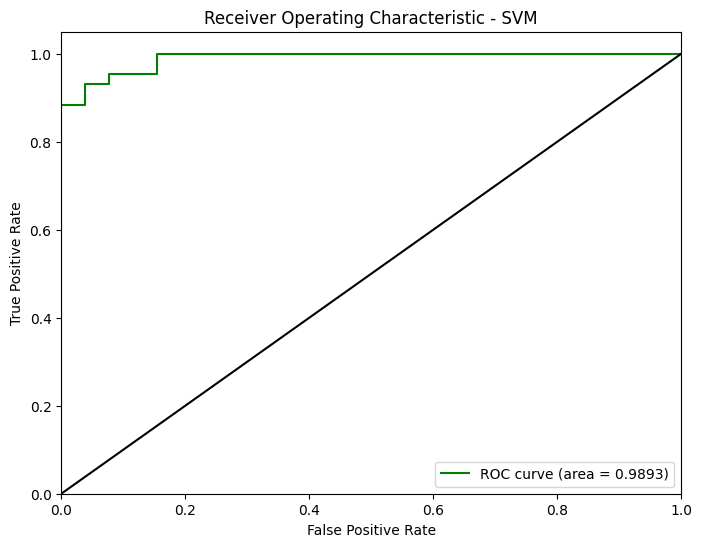

Fold 2 SVM Validation Accuracy: 0.912


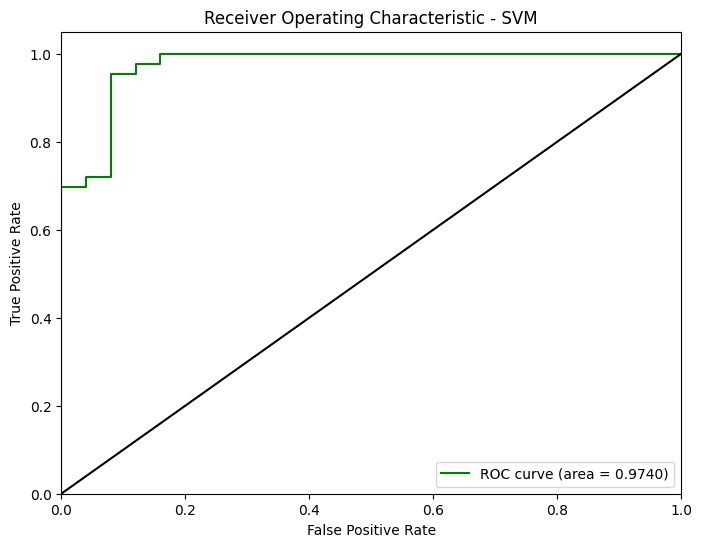

Fold 3 SVM Validation Accuracy: 0.985


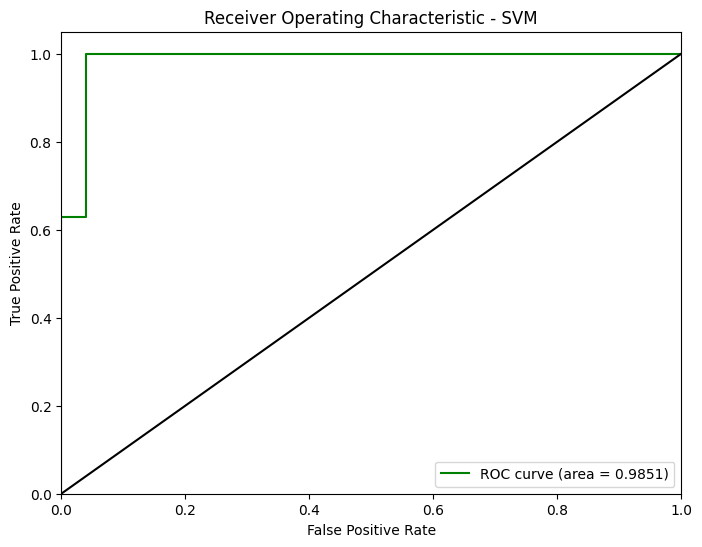

Fold 4 SVM Validation Accuracy: 0.956


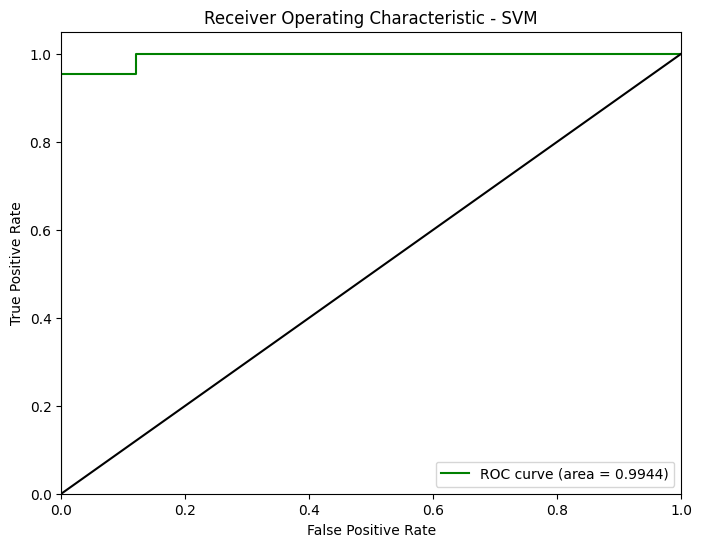

Fold 5 SVM Validation Accuracy: 0.956


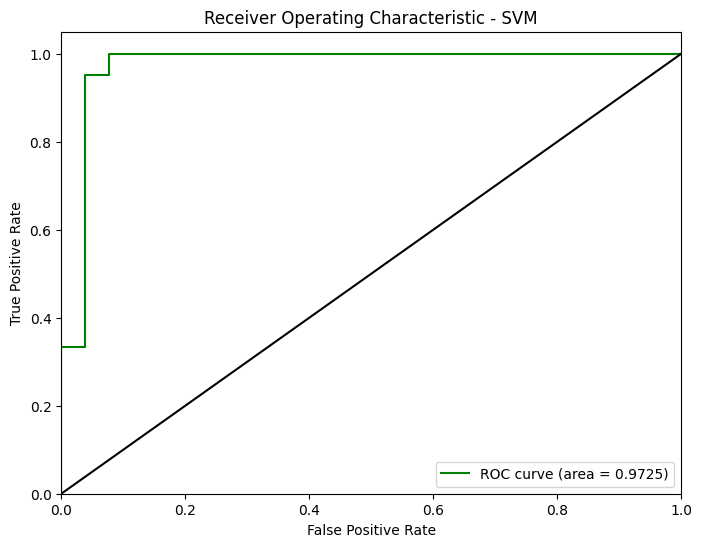


SVM Mean Validation Accuracy: 0.947
SVM Standard Deviation of Validation Accuracy: 0.025


In [ ]:
svm = LinearSVC(random_state=42, max_iter=10000)
accuracy_scores = []

for split in range(1,6):
    X_tr, X_val = X_train.iloc[x_training_splits[split-1][0]], X_train.iloc[x_training_splits[split-1][1]]
    y_tr, y_val = y_train.iloc[x_training_splits[split-1][0]], y_train.iloc[x_training_splits[split-1][1]]
    
    svm.fit(X_tr, y_tr)
    val_pred = svm.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    print(f"Fold {split} SVM Validation Accuracy: {val_acc:.3f}")
    accuracy_scores.append(val_acc)
    plot_roc_curve(y_val, svm.decision_function(X_val), "SVM")

mean_acc = np.mean(accuracy_scores)
std_acc = np.std(accuracy_scores)
print(f"\nSVM Mean Validation Accuracy: {mean_acc:.3f}")
print(f"SVM Standard Deviation of Validation Accuracy: {std_acc:.3f}")



### RBF kernel

Fold 1 RBF Kernel SVM Validation Accuracy: 0.623


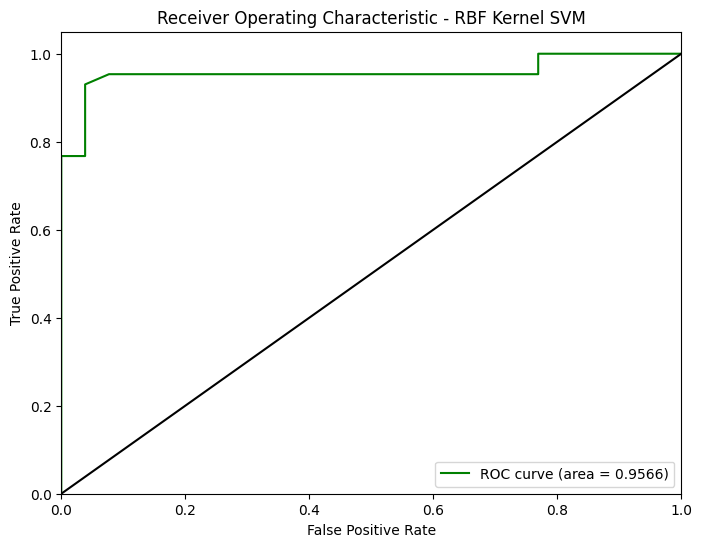

Fold 2 RBF Kernel SVM Validation Accuracy: 0.632


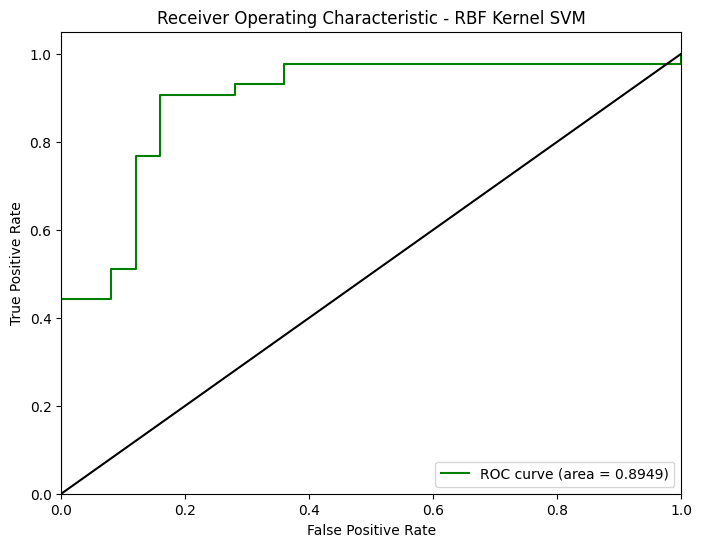

Fold 3 RBF Kernel SVM Validation Accuracy: 0.632


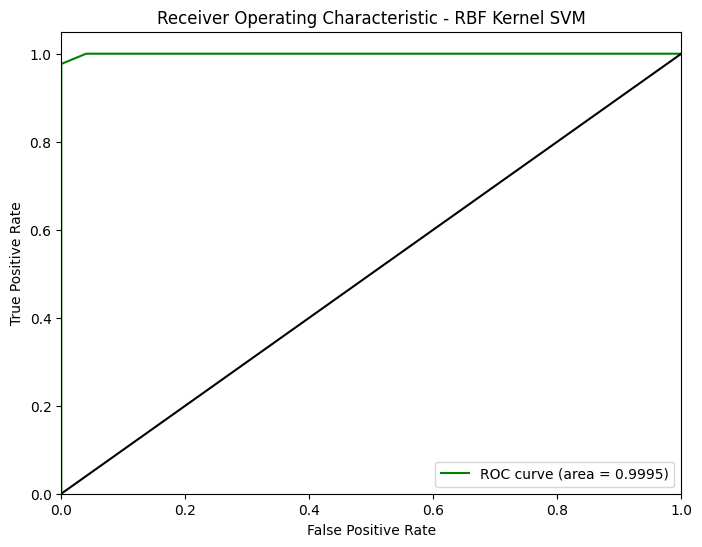

Fold 4 RBF Kernel SVM Validation Accuracy: 0.632


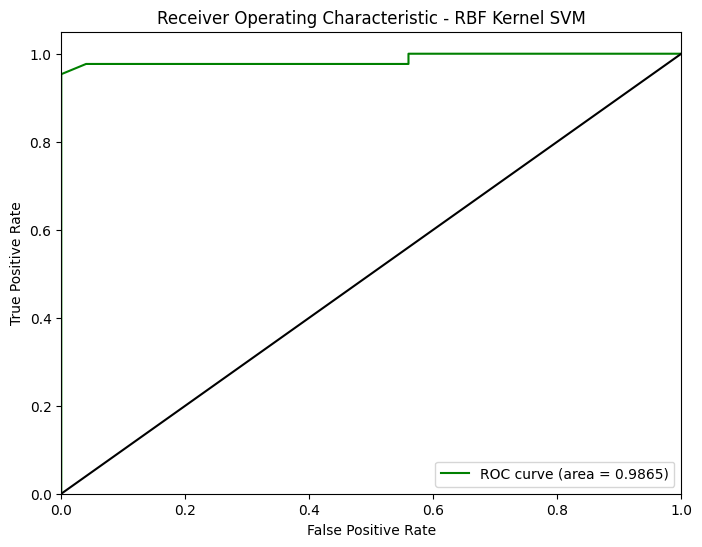

Fold 5 RBF Kernel SVM Validation Accuracy: 0.618


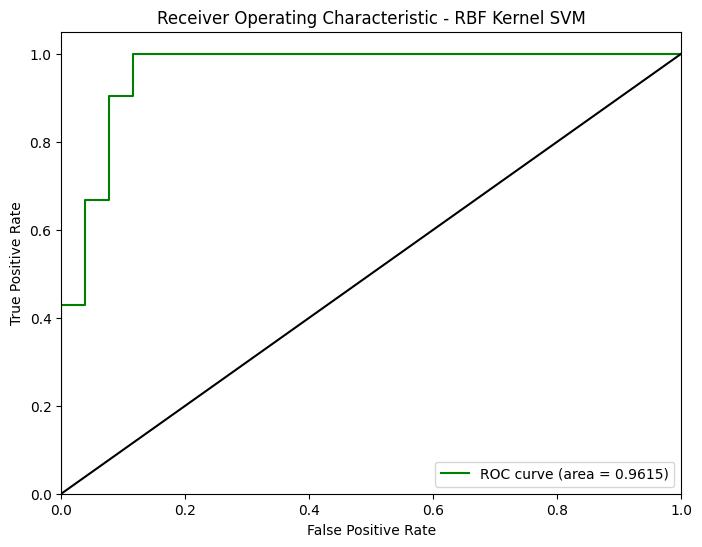


RBF Kernel SVM Mean Validation Accuracy: 0.628
RBF Kernel SVM Standard Deviation of Validation Accuracy: 0.006


In [ ]:
rbf_kernel_svm = sklearn.svm.SVC(kernel='rbf', probability=True, random_state=42, gamma=1, C=1)
accuracy_scores = []

for split in range(1,6):
    X_tr, X_val = X_train.iloc[x_training_splits[split-1][0]], X_train.iloc[x_training_splits[split-1][1]]
    y_tr, y_val = y_train.iloc[x_training_splits[split-1][0]], y_train.iloc[x_training_splits[split-1][1]]
    
    rbf_kernel_svm.fit(X_tr, y_tr)
    val_pred = rbf_kernel_svm.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    print(f"Fold {split} RBF Kernel SVM Validation Accuracy: {val_acc:.3f}")
    accuracy_scores.append(val_acc)
    plot_roc_curve(y_val, rbf_kernel_svm.decision_function(X_val), "RBF Kernel SVM")
mean_acc = np.mean(accuracy_scores)
std_acc = np.std(accuracy_scores)
print(f"\nRBF Kernel SVM Mean Validation Accuracy: {mean_acc:.3f}")
print(f"RBF Kernel SVM Standard Deviation of Validation Accuracy: {std_acc:.3f}")

### Test different gammas

In [ ]:
gamma_x = []
accuracy_y = []
for gamma in np.arange(0.0, 1, 0.1):
    rbf_kernel_svm = sklearn.svm.SVC(kernel='rbf', probability=True, random_state=42, gamma=gamma, C=1)
    
    rbf_kernel_svm.fit(X_tr, y_tr)
    val_pred = rbf_kernel_svm.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    print(f"Gamma: {gamma:.1f}, RBF Kernel SVM Validation Accuracy: {val_acc:.3f}")

    gamma_x.append(gamma)
    accuracy_y.append(val_acc)


Gamma: 0.0, RBF Kernel SVM Validation Accuracy: 0.618
Gamma: 0.1, RBF Kernel SVM Validation Accuracy: 0.985
Gamma: 0.2, RBF Kernel SVM Validation Accuracy: 0.985
Gamma: 0.3, RBF Kernel SVM Validation Accuracy: 0.868
Gamma: 0.4, RBF Kernel SVM Validation Accuracy: 0.794
Gamma: 0.5, RBF Kernel SVM Validation Accuracy: 0.691
Gamma: 0.6, RBF Kernel SVM Validation Accuracy: 0.632
Gamma: 0.7, RBF Kernel SVM Validation Accuracy: 0.618
Gamma: 0.8, RBF Kernel SVM Validation Accuracy: 0.618
Gamma: 0.9, RBF Kernel SVM Validation Accuracy: 0.618


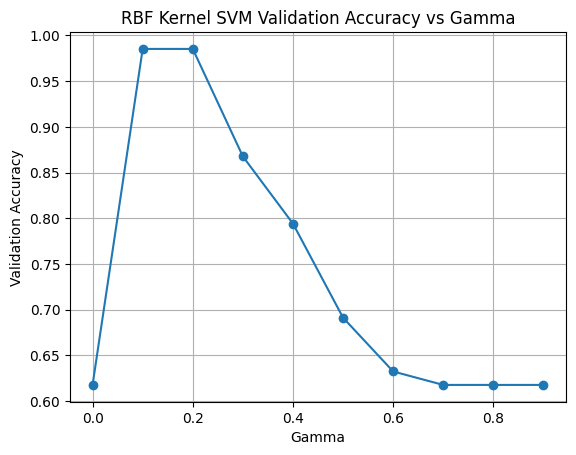

In [ ]:
plt.plot(gamma_x, accuracy_y, marker='o')
plt.xlabel("Gamma")
plt.ylabel("Validation Accuracy")
plt.title("RBF Kernel SVM Validation Accuracy vs Gamma")
plt.grid()
plt.show()


### Test different C values

In [ ]:
C_x = []
accuracy_y = []
for C in np.arange(0.1, 2.5, 0.2):
    rbf_kernel_svm = sklearn.svm.SVC(kernel='rbf', probability=True, random_state=42, gamma=0.1, C=C)
    rbf_kernel_svm.fit(X_train, y_train)

    val_pred = rbf_kernel_svm.predict(X_validation)
    val_acc = accuracy_score(y_validation, val_pred)
    print(f"C: {C:.1f}, RBF Kernel SVM Validation Accuracy: {val_acc:.3f}")
    C_x.append(C)
    accuracy_y.append(val_acc)


C: 0.1, RBF Kernel SVM Validation Accuracy: 0.956
C: 0.3, RBF Kernel SVM Validation Accuracy: 0.956
C: 0.5, RBF Kernel SVM Validation Accuracy: 0.965
C: 0.7, RBF Kernel SVM Validation Accuracy: 0.965
C: 0.9, RBF Kernel SVM Validation Accuracy: 0.974
C: 1.1, RBF Kernel SVM Validation Accuracy: 0.982
C: 1.3, RBF Kernel SVM Validation Accuracy: 0.991
C: 1.5, RBF Kernel SVM Validation Accuracy: 0.991
C: 1.7, RBF Kernel SVM Validation Accuracy: 0.991
C: 1.9, RBF Kernel SVM Validation Accuracy: 0.982
C: 2.1, RBF Kernel SVM Validation Accuracy: 0.982
C: 2.3, RBF Kernel SVM Validation Accuracy: 0.982


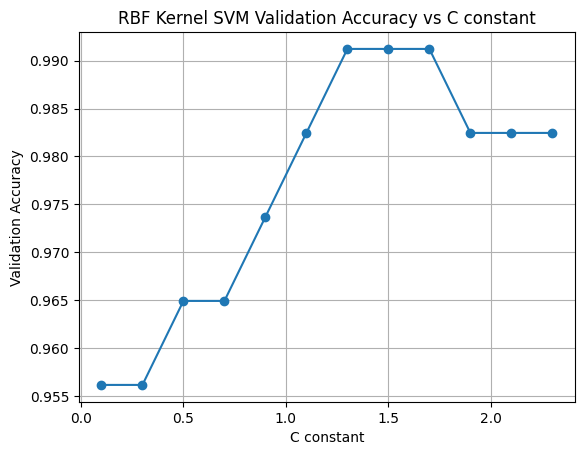

In [ ]:
plt.plot(C_x, accuracy_y, marker='o')
plt.xlabel("C constant")
plt.ylabel("Validation Accuracy")
plt.title("RBF Kernel SVM Validation Accuracy vs C constant")
plt.grid()
plt.show()

In [ ]:
final_svm_model = sklearn.svm.SVC(kernel='rbf', probability=True, random_state=42, gamma=0.1, C=1.5)
final_svm_model.fit(X_train, y_train)
final_svm_val_pred = final_svm_model.predict(X_validation)

accuracy_scores = []


for split in range(1,6):
    X_tr, X_val = X_train.iloc[x_training_splits[split-1][0]], X_train.iloc[x_training_splits[split-1][1]]
    y_tr, y_val = y_train.iloc[x_training_splits[split-1][0]], y_train.iloc[x_training_splits[split-1][1]]

    val_pred = final_svm_model.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    print(f"Fold {split} RBF Kernel SVM Validation Accuracy: {val_acc:.3f}")
    accuracy_scores.append(val_acc)
    
mean_acc = np.mean(accuracy_scores)
std_acc = np.std(accuracy_scores)
print(f"\nFinal RBF Kernel SVM Mean Validation Accuracy: {mean_acc:.3f}")
print(f"Final RBF Kernel SVM Standard Deviation of Validation Accuracy: {std_acc:.3f}")



Fold 1 RBF Kernel SVM Validation Accuracy: 1.000
Fold 2 RBF Kernel SVM Validation Accuracy: 0.985
Fold 3 RBF Kernel SVM Validation Accuracy: 1.000
Fold 4 RBF Kernel SVM Validation Accuracy: 1.000
Fold 5 RBF Kernel SVM Validation Accuracy: 0.985

Final RBF Kernel SVM Mean Validation Accuracy: 0.994
Final RBF Kernel SVM Standard Deviation of Validation Accuracy: 0.007


Tested both regulariazation parameteres gamma and C and the best accuracy result was with gamma around 0.1 and C around 1.5

The C regularization penalizes misclassification, but too high of a value will make the model overfit on the training data. The gamma controls the influence of the training examples, where a high gamma makes hard hard edges and makes the data overfit. Both parameters tends to pull the model in the same direction and a too low value makes the bias increase, but higher values increases makes a more complex model and introduces more variance. So there is a tradeoff.

### comparison validation set

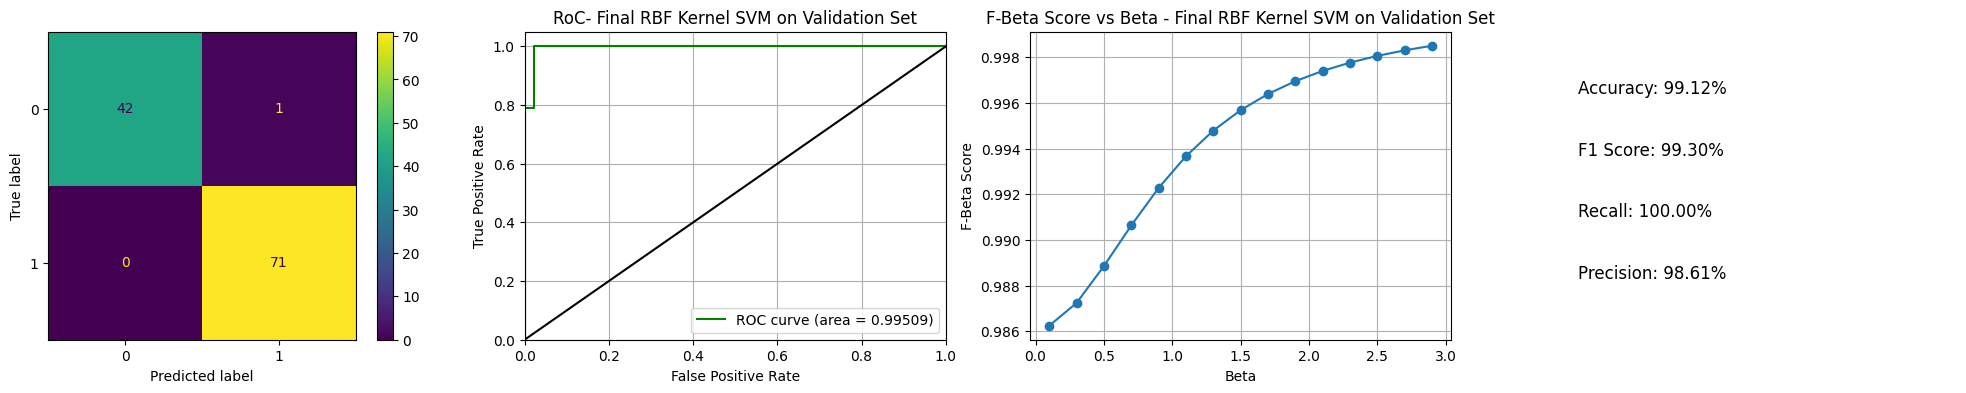

In [ ]:
plot_performance(X_validation, y_validation, final_svm_model, "Final RBF Kernel SVM on Validation Set")

## Exercise-4: Model Comparison

In [ ]:
X_test_scaled = num_pipeline.transform(X_test)
X_test_scaled = pd.DataFrame(
    X_test_scaled,
    columns=X_test.columns, 
    index=X_test.index      
)

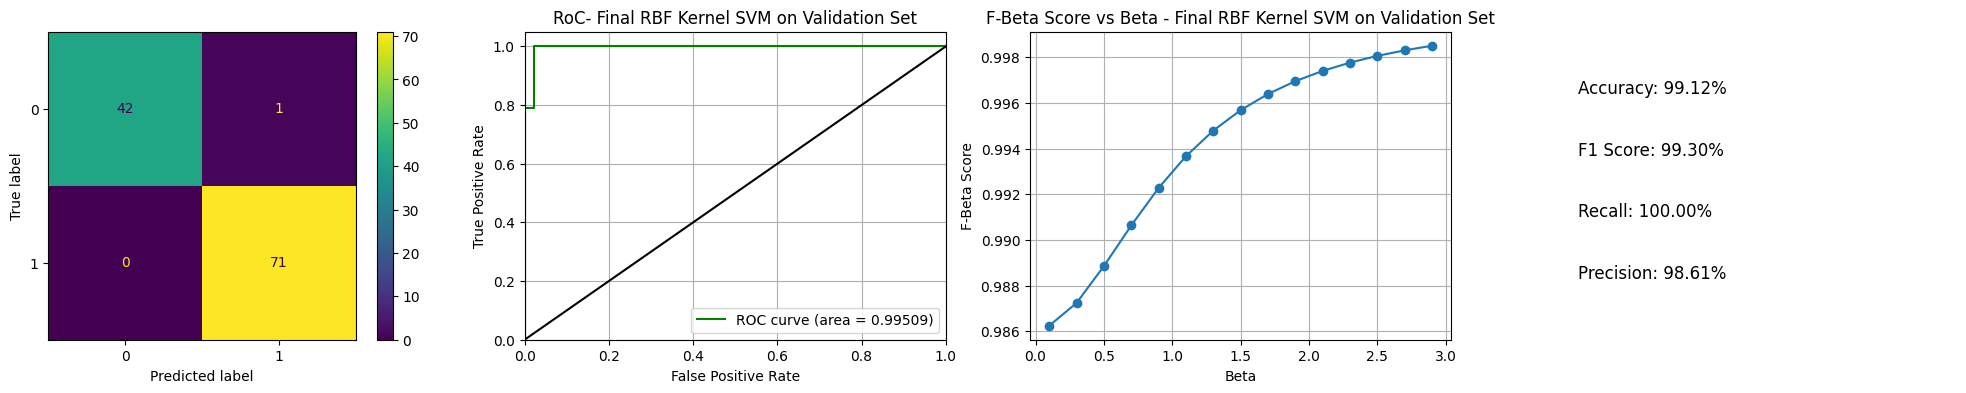

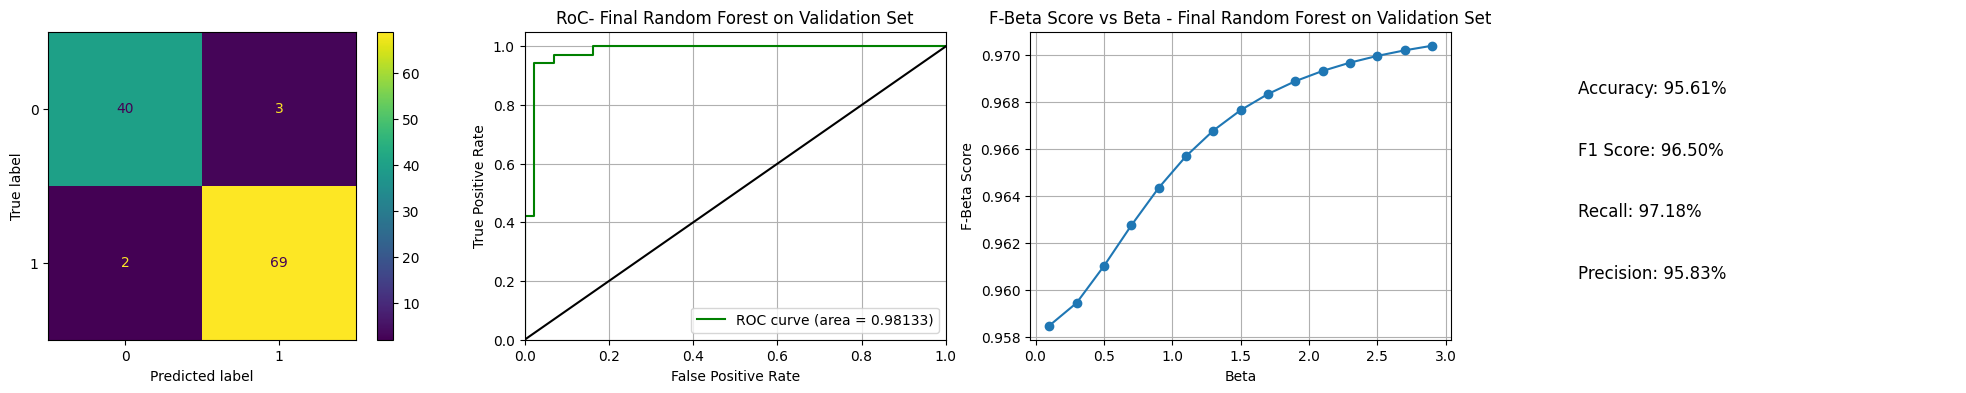

In [ ]:
plot_performance(X_validation, y_validation, final_svm_model, "Final RBF Kernel SVM on Validation Set")
plot_performance(X_validation, y_validation, final_tree_model, "Final Random Forest on Validation Set")



So from training the random forest estimator got a mean training accuracy at 96.8% on 5 splits and against validation got 95.1% accuracy. The SVM with rbf kernel got a 99.4 mean accuracy on training with 5 splits and a 99.12% accuracy on validation set. It seems like the SVM with rbf kernel have an overall better score than the decision tree and generalizes better

### Q4.2 Discuss the trade-off between usability and accuracy for this dataset. Which model would you recommend for a medical decision-support system, and why? (Hint - make use of Fβ score analysis)

For medical usages you would want to have a low false negative rate, because you want to be sure that you catch the diagnosis, even if it means some more false positives. This mean you want to weight recall more, because it penalizes false negatives. This means you want a high beta, which give more weight to the F score if you have high recall. We see from the plotted f beta score that at very high beta value the SVM beats out the random forest estimator and we should thus use that one.

### Q4.3 Use GridSearchCV with the training set to tune hyperparameters for both Decision Trees and SVMs. Confirm your final choice with the validation set. Summarize the best settings and provide relevant performance plots.


In [ ]:
param_grid_svm = {
    'C': [0.1, 0.15, 0.5, 1, 1.5, 2],
    'gamma': ['scale', 'auto', 0.01, 0.1],
    'kernel': ['rbf']
}


from sklearn.model_selection import GridSearchCV

grid_search_svm = GridSearchCV(sklearn.svm.SVC(probability=True, random_state=42), param_grid_svm, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)
print("Best parameters for SVM: ", grid_search_svm.best_params_)
print("Best cross-validation accuracy for SVM: ", grid_search_svm.best_score_)
best_svm_model = grid_search_svm.best_estimator_
val_pred_svm = best_svm_model.predict(X_validation)
val_acc_svm = accuracy_score(y_validation, val_pred_svm)
print(f"SVM Validation Accuracy with best params: {val_acc_svm*100:.2f}%")

Best parameters for SVM:  {'C': 1.5, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation accuracy for SVM:  0.9706308610400682
SVM Validation Accuracy with best params: 98.25%


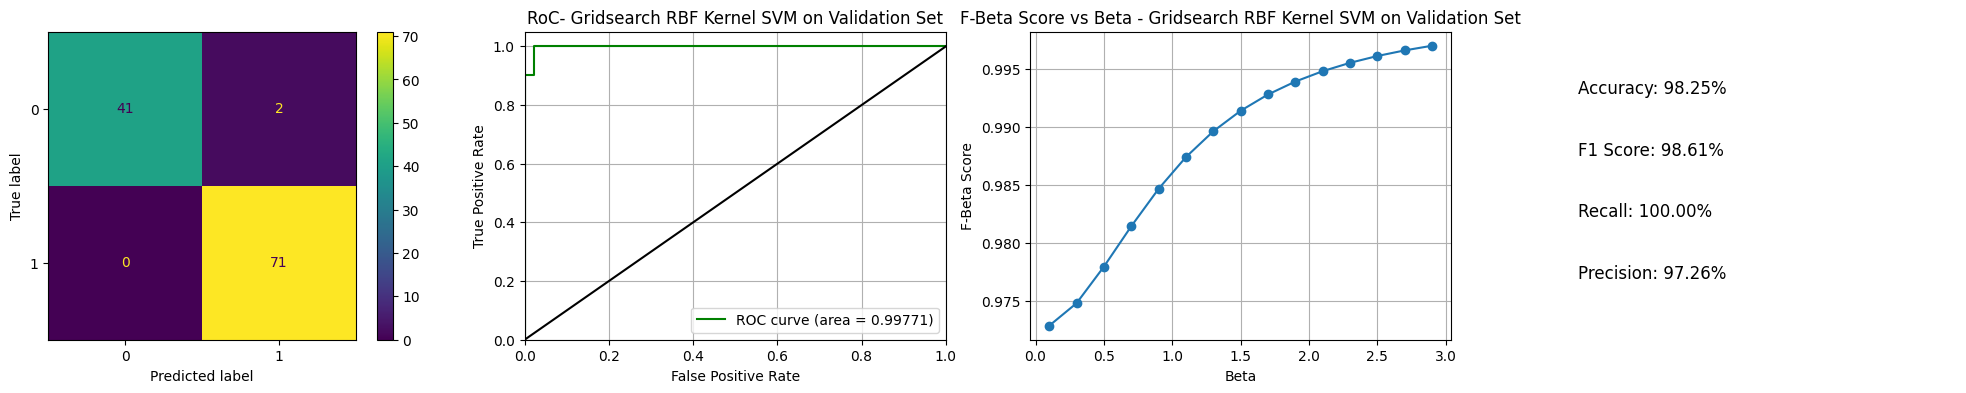

In [ ]:
plot_performance(X_validation, y_validation, best_svm_model, "Gridsearch RBF Kernel SVM on Validation Set")

In [ ]:
param_grid_rf = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}
grid_search_rf = GridSearchCV(sklearn.ensemble.RandomForestClassifier(random_state=42), param_grid_rf, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
print("Best parameters for Random Forest: ", grid_search_rf.best_params_)
print("Best cross-validation accuracy for Random Forest: ", grid_search_rf.best_score_)
best_rf_model = grid_search_rf.best_estimator_
val_pred_rf = best_rf_model.predict(X_validation)
val_acc_rf = accuracy_score(y_validation, val_pred_rf)
print(f"Random Forest Validation Accuracy with best params: {val_acc_rf*100:.2f}%") 



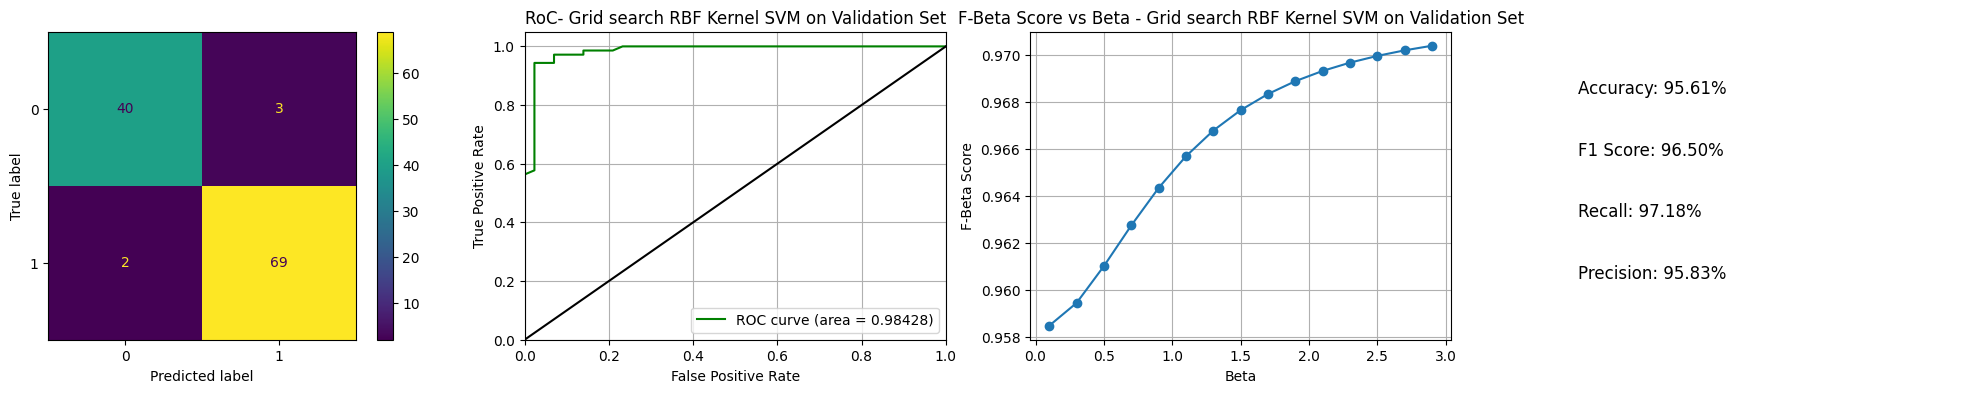

In [ ]:
plot_performance(X_validation, y_validation, best_rf_model, "Grid search RBF Kernel SVM on Validation Set")

We see that for the gridsearched svm it chooses C = 1.5 and gamma is selected auto, it however gives a worse performance than our handpicked parameters. For the random forest, however, the result is the same as our handpicked parameters. So after testing against validation the best parameters for SVM = 1.5 and Gamma = 0.1 while the random forest uses max_depth=6, min_samples_leaf=3, n_estimators=200

### Q4.4 Compare the final test set accuracy of the best Decision Tree and best SVM. Which model performs better in practice?

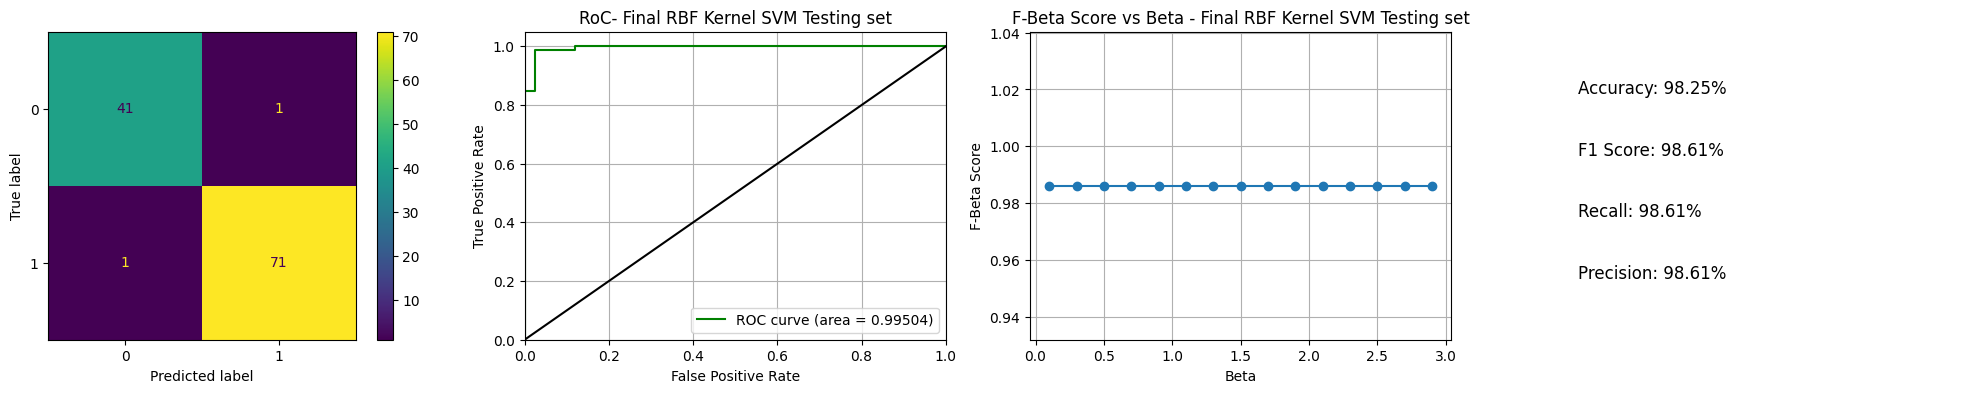

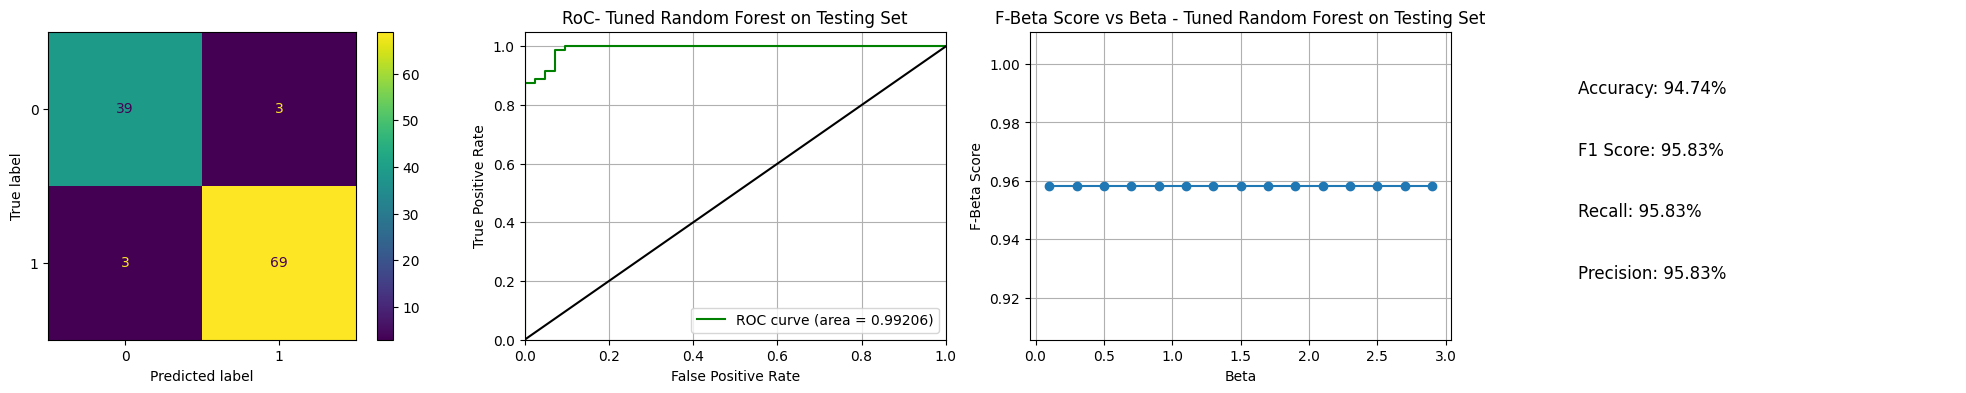

In [ ]:
plot_performance(X_test_scaled, y_test, best_svm_model, "Final RBF Kernel SVM Testing set")

plot_performance(X_test_scaled, y_test, best_rf_model, "Tuned Random Forest on Testing Set")

We see that against the testing set, both the models drops in accuracy. The svm goes from 99.12% to 98.25%, and the ROC area goes from 0.9951 to 0.9951. 

The Random forest goes from accuracy 95.61% to 94.74% and roc area goes from 0.9813 up to 0.9921.

For the unseen data the svm with rbf kernel performs best and generalizes best.

### Q4.5 The Breast Cancer Wisconsin dataset has 30 continuous features, many of which are correlated and not linearly separable. Explain why a linear SVM might fail to capture complex patterns in this dataset. How does using an RBF kernel helpin this case? Discuss your answer in terms of the dataset’s feature  space and the geometry of the decision boundary.

SVM tries to create a seperation between the classes, but when using linear model and there is not a linear plane seperating the classes, the model can drop in performance. This can be worsened by correlated features, because it is hard to linearly seperate based on features, if they are correlated. RBF transforms the data into a higher-dimensional feature space, by adding a feature for similarity in distance. These new features make the data be able to more clearly seperate and works better for complex data with correlated features.